# Reinforcement Learning
Use the already provided environment (that can be modified) to train an agent to reach the goal. The initial environment is given by a 10x10 empty grid where the agent start from a random position and has to reach a fixed goal position.

Let's start with this environment, we will train the agent with many epochs

In [159]:
# 'autoreload' allows to update modules without resetting the kernel 
%load_ext autoreload
%autoreload 2

import dill
import numpy as np
import matplotlib.pyplot as plt

import agent
import environment
import training


episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [2,2]            # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm

ep_per_epoch = 100      # print results nd store model each 'ep_per_epoch' episodes
initial = [7,7]         # Initial state (set None to have random ones)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def training(agent, x, y, initial, goal, softmax=False, sarsa=False, log=True,
             episodes=3000, discount=0.9, ep_per_epoch=100, episode_length=50):
    
    # TODO alpha and epsilon profile
    alpha = np.ones(episodes) * 0.25
    epsilon = np.linspace(0.8, 0.001,episodes)
    
    # initialize the agent (grid with 'x*y' states and 5 possible actions)
    learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

    # perform the training
    mean_reward = 0
    for index in range(0, episodes):

        # start from a random state if it was set to None
        if initial == None:
            initial = [np.random.randint(0, x), np.random.randint(0, y)]
        # initialize environment
        state = initial
        env = environment.Environment(x, y, state, goal)
        reward = 0

        # run episode
        for step in range(0, episode_length):

            # find state index
            state_index = state[0] * y + state[1]
            # choose an action
            action = learner.select_action(state_index, epsilon[index])
            # the agent moves in the environment
            result = env.move(action)
            # Q-learning update
            next_index = result[0][0] * y + result[0][1]
            learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
            # update state and reward
            reward += result[1]
            state = result[0]

        reward /= episode_length
        mean_reward += reward/ep_per_epoch

        # periodically save the agent and print results
        if ((index + 1) % ep_per_epoch == 0):
            with open('agent.obj', 'wb') as agent_file:
                dill.dump(agent, agent_file)
            
            if log:
                print('Episodes',index-99,'-',index+1,':  Mean of single episode average rewards is', np.round(mean_reward,4)) 
            if (index+1)<episodes:
                mean_reward = 0
            
    return mean_reward 


In [160]:
# initialize the agent (grid with 'x*y' states and 5 possible actions)
learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Train the agent
mean_rewards_per_step = training.train_agent(learner, x, y, initial, goal, episodes)

Episodes 0-100: Mean reward per step is -0.0714
Episodes 100-200: Mean reward per step is -0.0584
Episodes 200-300: Mean reward per step is -0.0534
Episodes 300-400: Mean reward per step is -0.0438
Episodes 400-500: Mean reward per step is -0.0258
Episodes 500-600: Mean reward per step is -0.002
Episodes 600-700: Mean reward per step is 0.029
Episodes 700-800: Mean reward per step is 0.0684
Episodes 800-900: Mean reward per step is 0.0916
Episodes 900-1000: Mean reward per step is 0.148
Episodes 1000-1100: Mean reward per step is 0.1762
Episodes 1100-1200: Mean reward per step is 0.2444
Episodes 1200-1300: Mean reward per step is 0.2824
Episodes 1300-1400: Mean reward per step is 0.3546
Episodes 1400-1500: Mean reward per step is 0.4012
Episodes 1500-1600: Mean reward per step is 0.4856
Episodes 1600-1700: Mean reward per step is 0.555
Episodes 1700-1800: Mean reward per step is 0.6192
Episodes 1800-1900: Mean reward per step is 0.6808
Episodes 1900-2000: Mean reward per step is 0.7586

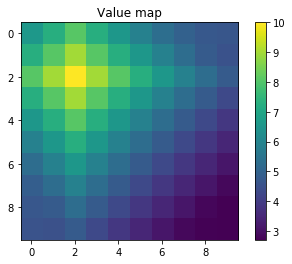

Mean reward per step = 0.8
GIF is stored as results/empty_grid.gif


In [161]:
#plot the learned Q-values and play on episode
learner.visualize_values(x,y)
training.play_episode_gif('results/empty_grid.gif', learner, x, y, initial, goal)

It has been observed that starting from a random point or from a fixed one will not impact significately the heatmap of the Q-values, so the next section will use [7,7] as a fixed initial point. </br>
In this case, the agent can arrive to the goal in 10 steps and in the best case scenario it can spend 40 steps in the goal position, so the maximum mean reward per step that it can obtain in this configuration is $0.8$.

The distribution estimated values showed in the heatmap is correct, but it is possible to check that also their magnitude makes sense given the specific discount rate $\gamma=0.9$. </br>
Consider the estimated value of the goal state. Once that the agent arrives there, we compute the value that it should have when using the optimal policy:

$$ V_{goal} = \sum^{N_{episodes}}_{i=0}\gamma^i R_{goal} = \sum^{N_{episodes}}_{i=0}\gamma^i \sim \frac{1}{1-\gamma}$$
 
where the last form is true in the approximation of $N_{episodes}>>1$, and it is equal to $10$ when using a discount factor $\gamma=0.9$, which is the same result obtained through the training.

In [143]:
training.play_episode_gif('results/empty_grid.gif', learner, x, y, initial, goal)

Mean reward per step = 0.8
GIF is stored as results/empty_grid.gif


### Test performance using Q-learning/SARSA and $\epsilon$-greedy/softmax 

Now we will compare the two different algorithms (Q-learning/SARSA) using one of the two different policies ($\epsilon$-greedy/softmax). We will make this test twice: once using the default procedure of $\epsilon$ decay, which starts from $0.8$ and decreases linearly to reach $0.001$ at the endo of the training, and once using the same 
extremes but where the decreasing is done exponentially.

#### Linear decay of $\epsilon$


Training agent using  Q-learning + eps-greedy
Final value of mean reward per step is 0.751

Training agent using  Q-learning + Softmax
Final value of mean reward per step is 0.8

Training agent using  SARSA + eps-greedy
Final value of mean reward per step is 0.7468

Training agent using  SARSA + Softmax
Final value of mean reward per step is 0.8


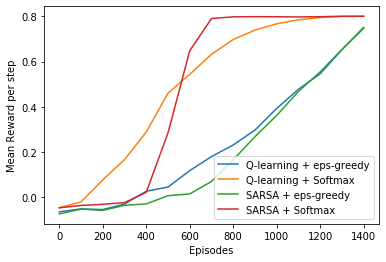

In [96]:
# Train the agent with all che combinations of algorithm and policy
episodes = 1500
training.compare_algorithms_and_policies(x, y, initial, goal, episodes)

#### Expoential decay of $\epsilon$

The exponential decay is computed in the following way: 

$$ \epsilon_{i+1} = \eta\epsilon_i ~~~ \text{where} ~~~ \eta<1 $$
 
Now we have to find the value of the decay factor $\eta$. We want that after $N_{episodes}$ the value is decreased from $\epsilon_0$ to $\epsilon_{end}$, so it must holds that

$$ \epsilon_{end} = \eta^{N_{episodes}} \epsilon_0 \implies \eta = \left( \frac{\epsilon_{end}}{\epsilon_0} \right)^{\frac{1}{N_{episodes}}}$$

Using the same extremes of the linear decay, we obtained $\eta=0.87486$


Training agent using  Q-learning + eps-greedy
Final value of mean reward per step is 0.794

Training agent using  Q-learning + Softmax
Final value of mean reward per step is 0.8

Training agent using  SARSA + eps-greedy
Final value of mean reward per step is 0.8

Training agent using  SARSA + Softmax
Final value of mean reward per step is 0.8


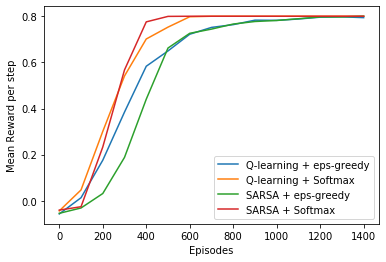

In [15]:
# Train the agent with all che combinations of algorithm and policy
episodes=1500
training.compare_algorithms_and_policies(x, y, initial, goal, 
                                         episodes, eps_decay_exp=True)

In [ ]:
initial = None
episodes = 3000 

# Test the 4 possible combinations of algorithm and policy
for case in range(4):
    
    # Set algorithm
    sarsa = case//2 
    if sarsa:
        algorithm = 'SARSA'
    else:
        algorithm = 'Q-learning'
        
    # Set policy
    softmax = case%2
    if softmax:
        policy = 'softmax'
    else:
        policy = 'eps-greedy'
    

    # Initialize the agent (grid with 'x*y' states and 5 possible actions)
    combination = algorithm +' + '+ policy
    print('\nTraining agent using ', algorithm+' + '+policy)
    learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)
    
    # Train model and store the Mean reward per step
    mean_rewards_per_step = training.train_agent(learner, x, y, initial, goal, episodes, log=False)
    plt.plot( np.arange(episodes//ep_per_epoch)*ep_per_epoch, mean_rewards_per_step, label=combination)
    print('Final value of mean reward per step is', np.round(mean_rewards_per_step[-1],4))
    
# Plot evolution of mean reward per step during training of each combination
plt.xlabel('Episodes')
plt.ylabel('Mean Reward per step')
plt.legend()
plt.show()

It is clear that an exponential decay of the $\epsilon$ makes the convergence faster for each method. This is particularly true for the Q-learning algorithm, which improved slower in the previous case because of the slower decrease of $\epsilon$ (the mean reward profile scales with $N_{episodes}$, so the convergence will be even slower when increasing $N_{episodes}$)

## Test agent on a maze

Here we will define and build a maze that the agent will hace to solve. By default, the walls will be considered insurmountable as the boudaries of the grid, then we will try to allow the agent to pass them, but penalizing it when it chooses to do so.

#### Unsurmountable walls
To be completed, the maze requires $42$ moves, so we chose to extend the episodes lenght to $168$ (which is four times the min number) and the best obtainable mean reward per step becomes $0.75$.

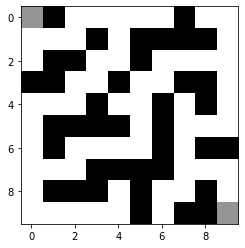

In [168]:
# Define maze structure, its goal and its initial state
# (walls are defined in this way just to give an idea of the maze)
x = 10
y = 10
initial = [9,9]
goal = [0,0]
walls = [      [0,1],                              [0,7],
                           [1,3],      [1,5],[1,6],[1,7],[1,8],
               [2,1],[2,2],            [2,5],
         [3,0],[3,1],            [3,4],            [3,7],[3,8],
                           [4,3],            [4,6],      [4,8],
               [5,1],[5,2],[5,3],[5,4],      [5,6],
               [6,1],                        [6,6],      [6,8],[6,9],
                           [7,3],[7,4],[7,5],[7,6],
               [8,1],[8,2],[8,3],      [8,5],            [8,8],
                                       [9,5],      [9,7],[9,8]
        ]

# Plot the maze
maze = np.zeros((x,y))
maze[np.asarray(walls).T[0], np.asarray(walls).T[1]] = 1
maze[goal[0], goal[1]] = 0.5
maze[initial[0], initial[1]] = 0.5

plt.imshow(maze, cmap='Greys')
plt.show()

Here we will find which combination of algorithms and policy performs better on the maze:


Training agent using  Q-learning + eps-greedy
Final value of mean reward per step is 0.7483

Training agent using  Q-learning + Softmax
Final value of mean reward per step is 0.75

Training agent using  SARSA + eps-greedy
Final value of mean reward per step is -0.0006

Training agent using  SARSA + Softmax
Final value of mean reward per step is 0.75


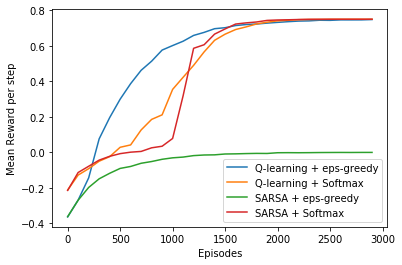

In [105]:
# Train the agent with all che combinations of algorithm and policy
episodes=3000
training.compare_algorithms_and_policies(x, y, initial, goal, episodes, walls=walls, 
                                         eps_decay_exp=True, episode_length=168)

The results are a bit different from the one obtained before, in particular for the SARSA algorithm with $\epsilon$-greedy policy, because its mean reward converges to zero at the end of the training (which means that the agent can't arrive to the goal state and get a positive reward). 

This is not a problem of exploration, since also setting the linear decrease for $\epsilon$ (which makes the $\epsilon$-greedy policy a lot more explorative) the agent could not solve the problem.

Episodes 0-100: Mean reward per step is -0.2037
Episodes 100-200: Mean reward per step is -0.111
Episodes 200-300: Mean reward per step is -0.0538
Episodes 300-400: Mean reward per step is 0.0022
Episodes 400-500: Mean reward per step is 0.0615
Episodes 500-600: Mean reward per step is 0.1583
Episodes 600-700: Mean reward per step is 0.2468
Episodes 700-800: Mean reward per step is 0.4126
Episodes 800-900: Mean reward per step is 0.5377
Episodes 900-1000: Mean reward per step is 0.6101
Episodes 1000-1100: Mean reward per step is 0.6695
Episodes 1100-1200: Mean reward per step is 0.7071
Episodes 1200-1300: Mean reward per step is 0.729
Episodes 1300-1400: Mean reward per step is 0.7381
Episodes 1400-1500: Mean reward per step is 0.7469
Episodes 1500-1600: Mean reward per step is 0.7481
Episodes 1600-1700: Mean reward per step is 0.7499
Episodes 1700-1800: Mean reward per step is 0.75
Episodes 1800-1900: Mean reward per step is 0.7499
Episodes 1900-2000: Mean reward per step is 0.75


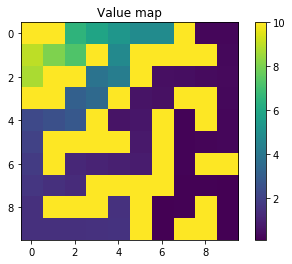

Mean reward per step = 0.75
GIF is stored as results/full_maze.gif


In [163]:
# Initialize the agent (grid with 'x*y' states and 5 possible actions)
learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=True, sarsa=False)

# Train the agent
episodes = 2000
mean_rewards_per_step = training.train_agent(learner, x, y, initial, goal, episodes, 
                                             eps_decay_exp=True, walls=walls, episode_length=168)

# Plot the results
learner.visualize_values(x,y)
training.play_episode_gif('results/full_maze.gif', learner, x, y, \
                          initial, goal, walls, episode_length=168)

From here it is possible to see that the value of each position increase as the agents gets close to the goal. As it is possible to see, the position corresponding the walls have the max value, but this does not mean that they are the best position to stay. This is due to the initialization of every value of the Q-table, which are equal to be $\frac{1}{1-\gamma}$, and since the agent can't reach those postitions, their value is never updated.

#### Surmountable walls
Here we will allow the agent to pass the walls for a negative reward. It will be interesting to study its behaviour as a function of this particular negative reward.


Training agent using  Q-learning + eps-greedy
Final value of mean reward per step is 0.7832

Training agent using  Q-learning + Softmax
Final value of mean reward per step is 0.7857

Training agent using  SARSA + eps-greedy
Final value of mean reward per step is -0.0015

Training agent using  SARSA + Softmax
Final value of mean reward per step is 0.7857


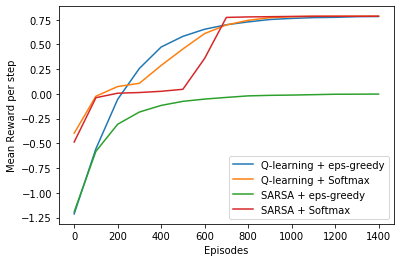

In [34]:
# Train the agent with all che combinations of algorithm and policy
episodes=1500
training.compare_algorithms_and_policies(x, y, initial, goal, episodes, walls=walls, wall_penal=-4, 
                                         eps_decay_exp=True, episode_length=168)

Episodes 0-100: Mean reward per step is -0.6396
Episodes 100-200: Mean reward per step is -0.2079
Episodes 200-300: Mean reward per step is 0.1718
Episodes 300-400: Mean reward per step is 0.4358
Episodes 400-500: Mean reward per step is 0.5891
Episodes 500-600: Mean reward per step is 0.6724
Episodes 600-700: Mean reward per step is 0.742
Episodes 700-800: Mean reward per step is 0.7755
Episodes 800-900: Mean reward per step is 0.8065
Episodes 900-1000: Mean reward per step is 0.8186
Episodes 1000-1100: Mean reward per step is 0.8281
Episodes 1100-1200: Mean reward per step is 0.8331
Episodes 1200-1300: Mean reward per step is 0.8373
Episodes 1300-1400: Mean reward per step is 0.8405
Episodes 1400-1500: Mean reward per step is 0.8432


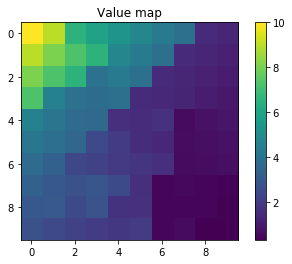

Mean reward per step = 0.8452380952380952
GIF is stored as results/soft_maze.gif


In [158]:
# initialize the agent (grid with 'x*y' states and 5 possible actions)
learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=False, sarsa=False)

# Train the agent
episodes = 1500
mean_rewards_per_step = training.train_agent(learner, x, y, initial, goal, episodes, 
                                             eps_decay_exp=True, walls=walls, 
                                             wall_penal=-2, episode_length=168)

# Plot results of the trained agent
learner.visualize_values(x,y)
training.play_episode_gif('results/soft_maze.gif', learner, x, y, \
                          initial, goal, walls, wall_penal=-2, episode_length=168)

Now we will find the value of `wall_penal` that makes the strategy of following the maze more efficient than the one of passing through the walls.

In [176]:
# Define all values of wall_penals
wall_penals = np.linspace(-4.5,-2,26)
mean_rewards = np.array([])
episodes = 1500

# Test all values and plot results
for wall_penal in wall_penals:
    
    # Define and train agent
    learner = agent.Agent((x * y), 5, discount, max_reward=1, softmax=True, sarsa=False)
    mean_rewards_per_step = training.train_agent(learner, x, y, initial, goal, episodes, 
                                        eps_decay_exp=True, walls=walls, wall_penal=wall_penal, 
                                        log=False, episode_length=168)
    
    # Store and rint results
    mean_rewards = np.append( mean_rewards, mean_rewards_per_step[-1] )
    print('Mean reward per step for wall_penal='+str(wall_penal)+' is', np.round(mean_rewards_per_step[-1],4))

Mean reward per step for wall_penal=-4.5 is 0.75
Mean reward per step for wall_penal=-4.4 is 0.75
Mean reward per step for wall_penal=-4.3 is 0.75
Mean reward per step for wall_penal=-4.2 is 0.7845
Mean reward per step for wall_penal=-4.1 is 0.7851
Mean reward per step for wall_penal=-4.0 is 0.7857
Mean reward per step for wall_penal=-3.9 is 0.7863
Mean reward per step for wall_penal=-3.8 is 0.7869
Mean reward per step for wall_penal=-3.7 is 0.7875
Mean reward per step for wall_penal=-3.6 is 0.7881
Mean reward per step for wall_penal=-3.5 is 0.7887
Mean reward per step for wall_penal=-3.4 is 0.7893
Mean reward per step for wall_penal=-3.3 is 0.7899
Mean reward per step for wall_penal=-3.2 is 0.7905
Mean reward per step for wall_penal=-3.0999999999999996 is 0.7911
Mean reward per step for wall_penal=-3.0 is 0.7917
Mean reward per step for wall_penal=-2.9 is 0.7923
Mean reward per step for wall_penal=-2.8 is 0.7929
Mean reward per step for wall_penal=-2.7 is 0.7935
Mean reward per step f

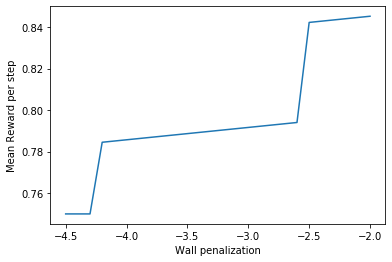

In [177]:
# Plot results
plt.xlabel('Wall penalization')
plt.ylabel('Mean Reward per step')
plt.plot(wall_penals, mean_rewards)
plt.show()

The strategy of going through walls is better even for lower values of `wall_penal`, but the high value of the discoùunt rate makes those choice less probable since the reward is many steps away. For example, the best strategy (for any `wall_penal` higher than `-20`) is discovered only at `wall_penal = -2.5`.